In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!!pip install --upgrade git+https://github.com/keras-team/keras-cv

['Collecting git+https://github.com/keras-team/keras-cv',
 '  Cloning https://github.com/keras-team/keras-cv to /tmp/pip-req-build-lo2x2_wl',
 '  Running command git clone --filter=blob:none --quiet https://github.com/keras-team/keras-cv /tmp/pip-req-build-lo2x2_wl',
 '  Resolved https://github.com/keras-team/keras-cv to commit d01aee44a73c228c1981ffd913fd7a96ad40b0c0',
 '  Installing build dependencies: started',
 "  Installing build dependencies: finished with status 'done'",
 '  Getting requirements to build wheel: started',
 "  Getting requirements to build wheel: finished with status 'done'",
 '  Preparing metadata (pyproject.toml): started',
 "  Preparing metadata (pyproject.toml): finished with status 'done'",
 'Requirement already satisfied: packaging in /opt/conda/lib/python3.10/site-packages (from keras-cv==0.6.1) (21.3)',
 'Requirement already satisfied: absl-py in /opt/conda/lib/python3.10/site-packages (from keras-cv==0.6.1) (1.4.0)',
 'Requirement already satisfied: regex

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import optimizers
import keras_cv
import numpy as np
from keras_cv import bounding_box
import os
import resource
from keras_cv import visualization
import tqdm
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

Using TensorFlow backend


In [4]:
pretrained_model = keras_cv.models.RetinaNet.from_preset(
    "retinanet_resnet50_pascalvoc", bounding_box_format="xywh"
)

142662880/142662880 [==============================] - 7s 0us/step


Format of the bounding boxes:
``` python
bounding_boxes = {
  "classes": [num_boxes],
  "boxes": [num_boxes, 4]
}
```

`bounding_box_format` argument describes what format the values in the `"boxes"` field of the label dictionary take in the pipeline.\
For example, a box with `xywh` format tells us coordinates of its top left corner, the next two coordinates means width an height of the bounding box.\
`"xyxy"` on the other hand tells us coordinates of top left and bottom right corners of the bounding box.\
For a box of width 55 and height 75 with coordinates of top left corner being (100,100) we will have following values of `bounding_box_format`:
* `"xywh"`: [100, 100, 55, 75]
* `"xyxy"`: [100, 100, 155, 175]
\
Every component that processes bounding boxes requires a `bounding_box_format` argument.\
This is done because there is no one correct format for bounding boxes. Components in different pipelines expect different formats, and so by requiring them to be spesificed we ensure that our components remain readable, reusable and clear.\
Bugs related to box format conversion are the most common in object detection pipelines.

In [18]:
image_paths=[
    "https://i.pinimg.com/originals/78/bd/3a/78bd3ae3ccaaa21f193dc49a51d4b281.jpg",
    "https://i.imgur.com/kTwKfRL.jpeg"
]

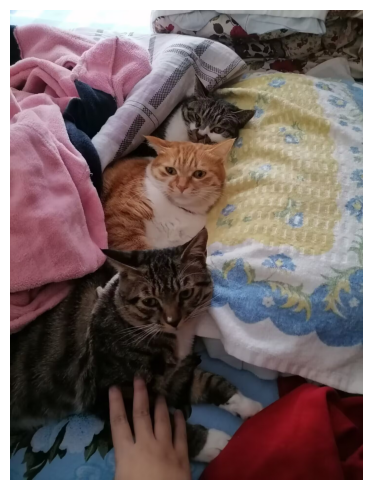

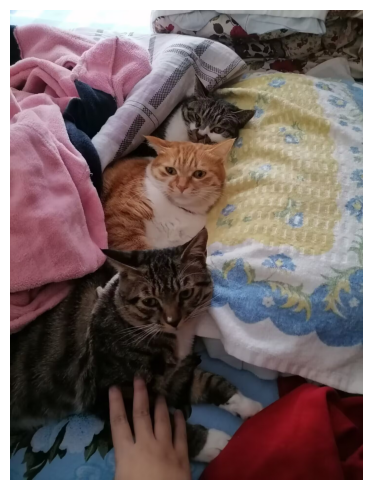

In [31]:
filepath = tf.keras.utils.get_file(origin=image_paths[1])
image = keras.utils.load_img(filepath)
image = np.array(image)

visualization.plot_image_gallery(
    np.array([image]),
    value_range=(0, 255),
    rows=1,
    cols=1,
    scale=5,
)

In [32]:
image.shape

(1920, 1440, 3)

In [33]:
inference_resizing = keras_cv.layers.Resizing(
    640, 640, pad_to_aspect_ratio=True, bounding_box_format="xywh"
)

In [34]:
image_batch = inference_resizing([image])

In [35]:
class_ids = [
    "Aeroplane",
    "Bicycle",
    "Bird",
    "Boat",
    "Bottle",
    "Bus",
    "Car",
    "Cat",
    "Chair",
    "Cow",
    "Dining Table",
    "Dog",
    "Horse",
    "Motorbike",
    "Person",
    "Potted Plant",
    "Sheep",
    "Sofa",
    "Train",
    "Tvmonitor",
    "Total",
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

In [36]:
y_pred = pretrained_model.predict(image_batch)

1/1 [==============================] - 1s 1s/step


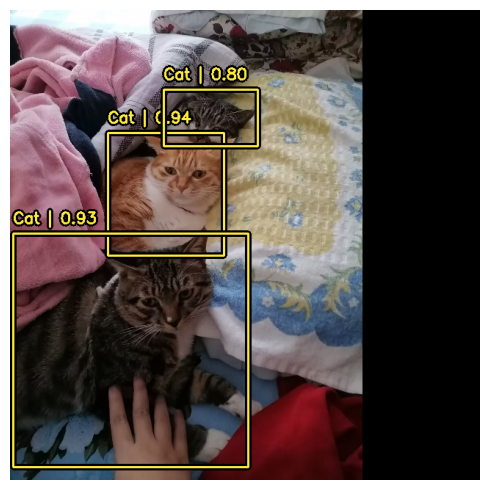

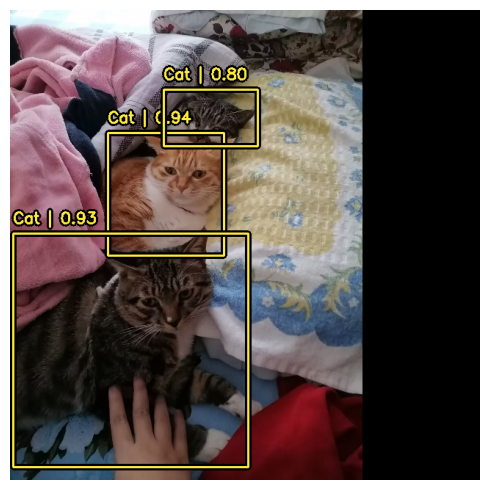

In [37]:
visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)

---

Now we will modify NonMaxSuppression modifying `iou_threshold` to `0.2` and `confidence_threshold` to `0.7`.\
This modification will cause the model to output boxes that have higher confidence score.\
*  `confidence_threshold` causes the model to output boxes that have higher confidence score.
* `iou_threshold` controls the threshold of intersection over union (IoU) that two boxes must have in order for one to be pruned out.

1/1 [==============================] - 3s 3s/step


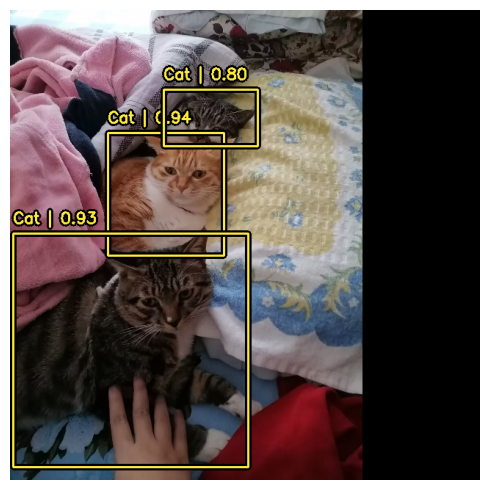

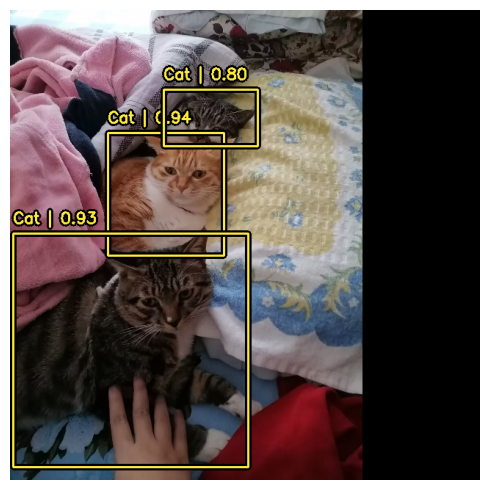

In [38]:
prediction_decoder = keras_cv.layers.MultiClassNonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    # Decrease the required threshold to make predictions get pruned out
    iou_threshold=0.05,
    # Tune confidence threshold for predictions to pass NMS
    confidence_threshold=0.7,
)
pretrained_model.prediction_decoder = prediction_decoder

y_pred = pretrained_model.predict(image_batch)
visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)